# Introduce

This notebook is created for training fingerprint recognition model.

This project is in Github. (https://github.com/JinZhuXing/Fingerprint_TF)

# Preprocess

## Environment Check

This notebook uses tensorflow(>= v2.0) for training.
First load python packages and check version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import os
import datetime


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU: ", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.10.0
Eager mode:  True
GPU:  NOT AVAILABLE


## Load Train Data

Load train and real data.
It opens preprocessed npy files.

In [2]:
img_data = np.load('dataset_FVC2000_DB4_B/dataset/np_data/img_train.npy')
label_data = np.load('dataset_FVC2000_DB4_B/dataset/np_data/label_train.npy')
img_real = np.load('dataset_FVC2000_DB4_B/dataset/np_data/img_real.npy')
label_real = np.load('dataset_FVC2000_DB4_B/dataset/np_data/label_real.npy')

print(img_data.shape, label_data.shape)
print(img_real.shape, label_real.shape)

(800, 160, 160, 1) (800, 1)
(10, 160, 160, 1) (10, 1)


### Histogram Stretch

Histogram Stretch for all train and real images.

In [3]:
def hist_stretch(img_buf, width, height, shift):
    tmp1 = 0
    tmp2 = 0
    w_pHistBuf = np.zeros(256, dtype=np.uint32)
    total = 0
    ret_buf = np.zeros((width, height, 1), dtype=np.uint8)

    # get brightness
    for i in range(height):
        for j in range(width):
            total = total + img_buf[i][j][0]
            w_pHistBuf[img_buf[i][j][0]] += 1
    diff = (int)(shift - (total / (width * height)))
    w_pHistBuf = np.zeros(256, dtype=np.uint32)

    # move histogram
    for i in range(height):
        for j in range(width):
            tmp = img_buf[i][j][0] + diff
            if (tmp > 255):
                tmp = 255
            elif (tmp < 0):
                tmp = 0
            ret_buf[i][j][0] = tmp
            w_pHistBuf[tmp] += 1

    # stretch histogram
    for i in range(256):
        if (w_pHistBuf[i] != 0):
            tmp1 = i
            break
    for i in range(255, 0, -1):
        if (w_pHistBuf[i] != 0):
            tmp2 = i
            break
    for i in range(height):
        for j in range(width):
            ret_buf[i][j][0] = (int)((255 * (ret_buf[i][j][0] - tmp1) / (tmp2 - tmp1)))
    
    return ret_buf

for i in range(img_data.shape[0]):
    img_tmp = hist_stretch(img_data[i], 160, 160, 128)
    img_data[i] = img_tmp
    
for i in range(img_real.shape[0]):
    img_tmp = hist_stretch(img_real[i], 160, 160, 128)
    img_real[i] = img_tmp

### Split Loaded Data

Split loaded data with 0.1 test size.

In [4]:
img_train, img_val, label_train, label_val = train_test_split(img_data, label_data, test_size = 0.1)
print(img_data.shape, label_data.shape)
print(img_train.shape, label_train.shape)
print(img_val.shape, label_val.shape)

(800, 160, 160, 1) (800, 1)
(720, 160, 160, 1) (720, 1)
(80, 160, 160, 1) (80, 1)


# Prepare Network

## Make Model Network

Make function for build model.

In [5]:
def build_model():
    x1 = layers.Input(shape = (160, 160, 1))
    x2 = layers.Input(shape = (160, 160, 1))

    # share weights both inputs
    inputs = layers.Input(shape = (160, 160, 1))
    feature = layers.Conv2D(32, kernel_size = 3, activation = 'relu')(inputs)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(64, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature_model = Model(inputs = inputs, outputs = feature)

    # show feature model summary
    feature_model.summary()

    # two feature models that sharing weights
    x1_net = feature_model(x1)
    x2_net = feature_model(x2)

    # subtract features
    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(net)
    net = layers.MaxPooling2D(pool_size = 2)(net)
    net = layers.Flatten()(net)
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(512, activation = 'relu')(net)
    net = layers.Dense(1, activation = 'sigmoid')(net)
    model = Model(inputs = [x1, x2], outputs = net)

    # compile
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['acc'])

    # show summary
    model.summary()

    return (model, feature_model)

## Make Data Generator

Prepare data generator for training

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, img_real, label_real, batch_size = 32, shuffle = True):
        'Initialization'
        self.img_data = img_data
        self.label_data = label_data
        self.img_real = img_real
        self.label_real = label_real
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        'Generate one batch of data'
        real_idx = index
        index = int(np.floor(index / 2))
        img1_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label1_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]
        img2_batch = np.empty((self.batch_size, 160, 160, 1), dtype = np.float32)
        label2_batch = np.zeros((self.batch_size, 1), dtype = np.float32)

        for i, idx in enumerate(label1_batch):
            if random.random() > 0.5:
                # put matched image
                img2_batch[i] = self.img_real[idx]
                label2_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_idx = random.choice(list(self.label_real))
                    if (unmatch_idx != idx):
                        break

                img2_batch[i] = self.img_real[unmatch_idx]
                label2_batch[i] = 0.
                
        index = real_idx
        if (index < int(np.floor(len(self.img_data) / self.batch_size))):
            return [img1_batch.astype(np.float32) / 255., img2_batch.astype(np.float32) / 255.], label2_batch
        
        return [img2_batch.astype(np.float32) / 255., img1_batch.astype(np.float32) / 255.], label2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)

### Prepare Generator for train and validation

Prepare generator for train and validation

In [7]:
train_gen = DataGenerator(img_train, label_train, img_real, label_real, shuffle = True)
val_gen = DataGenerator(img_val, label_val, img_real, label_real, shuffle = True)

# Train Model

Train model.

## Configure Checkpoint

Prepare checkpoint data

In [8]:
checkpoint_path = '/kaggle/working/model/checkpoint/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

## Prepare Tensorboard

Prepare tensorboard for monitor training

In [9]:
tfb_log_dir = '/kaggle/working/logs/train/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tfb_log_dir, histogram_freq = 1)

## Prepare Training

Prepare training

In [10]:
(model, feature_model) = build_model()
if (os.path.exists(checkpoint_path + '.index')):
    print('continue training')
    model.load_weights(checkpoint_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856 

c:\Users\srtul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Train

Train model

In [11]:
history = model.fit(train_gen, epochs = 200, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback])
#history = model.fit(train_gen, epochs = 200, validation_data = val_gen)

Epoch 1/200
44/44 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.5305
Epoch 1: saving model to /kaggle/working/model/checkpoint\cp.ckpt
44/44 [==============================] - 44s 968ms/step - loss: 0.6915 - acc: 0.5305 - val_loss: 0.6784 - val_acc: 0.5469
Epoch 2/200
44/44 [==============================] - ETA: 0s - loss: 0.6720 - acc: 0.5597
Epoch 2: saving model to /kaggle/working/model/checkpoint\cp.ckpt
44/44 [==============================] - 39s 897ms/step - loss: 0.6720 - acc: 0.5597 - val_loss: 0.6613 - val_acc: 0.5312
Epoch 3/200
44/44 [==============================] - ETA: 0s - loss: 0.6415 - acc: 0.6250
Epoch 3: saving model to /kaggle/working/model/checkpoint\cp.ckpt
44/44 [==============================] - 41s 942ms/step - loss: 0.6415 - acc: 0.6250 - val_loss: 0.6254 - val_acc: 0.6250
Epoch 4/200
44/44 [==============================] - ETA: 0s - loss: 0.6151 - acc: 0.6534
Epoch 4: saving model to /kaggle/working/model/checkpoint\cp.ckpt
44/44 [===

## Show Result

Draw trained history graph.

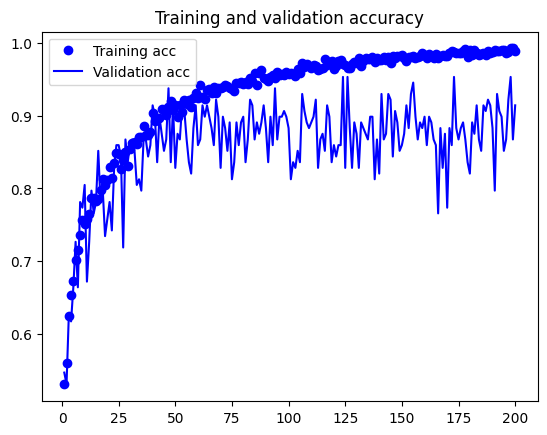

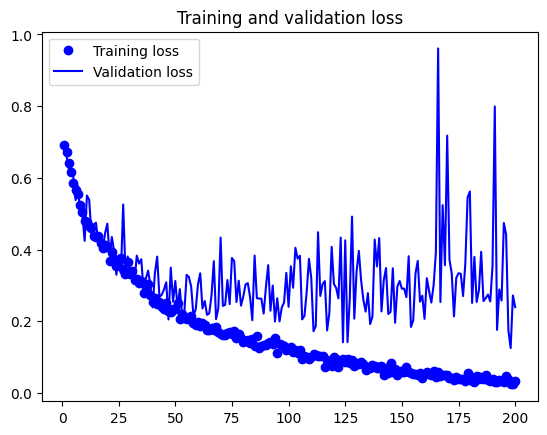

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Save Model

Save trained model as h5 file

In [13]:
model_path = '/kaggle/working/model/fp160.h5'
model_feature_path = '/kaggle/working/model/fp160_feature.h5'
model.save(model_path)
feature_model.save(model_feature_path)

# Evaluation

## Match Two Image

Match sample real two images.

1/1 [==============================] - 0s 224ms/step


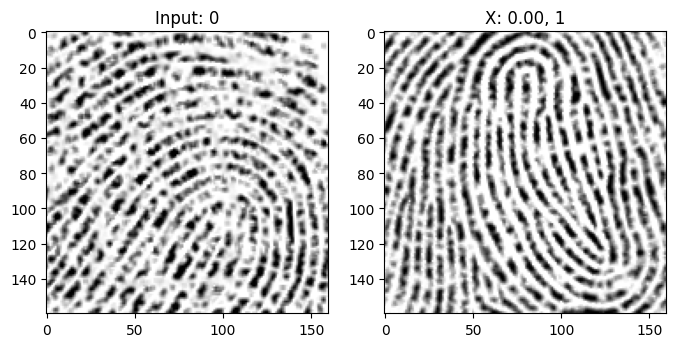

In [14]:
input_idx = 0
db_idx = 1
input_img = img_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
pred_right = model.predict([input_img, db_img])

# show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s' %input_idx)
plt.imshow(input_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
if (pred_right > 0.5):
    plt.title('O: %.02f, %s' % (pred_right, db_idx))
else:
    plt.title('X: %.02f, %s' % (pred_right, db_idx))
plt.imshow(db_img.squeeze(), cmap='gray')

## Evaluate with Real Image

Evaluate with all real images and calculate accuracy.

In [15]:
total_count = 0
error_count = 0
error_rage = 0.5
for input_idx in range(label_real.shape[0]):
    print('Processing #', input_idx, '')
    for db_idx in range(label_real.shape[0]):
        input_img = img_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        pred_right = model.predict([input_img, db_img])
        if (input_idx == db_idx):
            if (pred_right < error_rage):
                print('False Reject = ', pred_right)
                error_count += 1
        if (input_idx != db_idx):
            if (pred_right > error_rage):
                print('False Accept = ', pred_right, ', ID = ', db_idx)
                error_count += 1
        total_count += 1

# show result
print('Evaluation Finished')
print('Total Count = ', total_count)
print('Error Count = ', error_count)
print('Error Rate = ', (error_count / total_count) * 100)

Processing # 0 
1/1 [==============================] - 0s 30ms/step
Processing # 1 
1/1 [==============================] - 0s 30ms/step
Processing # 2 
1/1 [==============================] - 0s 28ms/step
Processing # 3 
1/1 [==============================] - 0s 28ms/step
Processing # 4 
1/1 [==============================] - 0s 28ms/step
Processing # 5 
1/1 [==============================] - 0s 31ms/step
Processing # 6 
1/1 [==============================] - 0s 30ms/step
Processing # 7 
1/1 [==============================] - 0s 28ms/step
Processing # 8 
1/1 [==============================] - 0s 27ms/step
Processing # 9 
1/1 [==============================] - 0s 27ms/step
Evaluation Finished
Total Count =  100
Error Count =  0
Error Rate =  0.0
